# Imports

In [224]:
import polars as pl
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from matplotlib import pyplot as plt
from typing import List
import pandas as pd
from sklearn.metrics import ndcg_score

# Parameters

In [225]:
label_column = "has_seen_venue_in_this_session"
pred_label = f"pred_{label_column}"
group_column = "session_id_hashed"
rank_column = "popularity"
rank_pos_column = "position_in_list"
predicted_rank_column = f"predicted_{rank_column}"
features = [
    'venue_id',
 'conversions_per_impression',
#  "purchased",
 'price_range',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'position_in_list',
#  'has_seen_venue_in_this_session',
#  'is_new_user',
 'is_from_order_again',
 'is_recommended']

# Utils

In [226]:
def convert_boolean_to_int(ranking_data):
    bool_cols = ranking_data.select(pl.col(pl.Boolean)).columns
    ranking_data = ranking_data.with_columns(
        [
            pl.col(column).cast(pl.Int8, strict=False).alias(column)
            for column in bool_cols
            ]
        )
    return ranking_data
def plot_lgb_report(lgb_model, evals_logs: dict, eval_at = [10, 20, 40]):
    for k in eval_at:
        fig, ax = plt.subplots(figsize=(12, 8))
        lgb.plot_metric(evals_logs, ax=ax, metric=f"ndcg@{k}")

        
    lgb.plot_importance(lgb_model, importance_type="gain", figsize=(14, 8))
    lgb.plot_importance(lgb_model, importance_type="split", figsize=(14, 8))
        
def qa_features(model: lgb, features: List[str]):
    feature_importance = {
        feature: importance
        for feature, importance in zip(
        model.feature_name(), model.feature_importance()
        )
    }
    print(feature_importance)
    used_features = [
        f for f in feature_importance
        if feature_importance[f] != 0
    ]
    dropped_features = [f for f in features if f not in used_features]
    print("-------------------------------------------------------")
    print("Used features: ")
    print(used_features)
    print("-------------------------------------------------------")
    print(
        f"passed {len(features)} "
        f"features and model used {len(used_features)} of them"
    )
    print("-------------------------------------------------------")
    print(f"these features were dropped: {dropped_features}")
    return used_features

def generate_predictions(
    test_set: pl.DataFrame, model: lgb, features_to_use: List[str]
) -> pd.DataFrame:
    test_set_pandas = test_set.sort(
        by=[group_column, rank_column], reverse=False
    ).to_pandas()
    test_set_pandas[features_to_use] = test_set_pandas[features_to_use].fillna(0)
    test_x = test_set_pandas[features_to_use]

    test_set_pandas[pred_label] = model.predict(test_x)
    test_set_pandas[predicted_rank_column] = (
        test_set_pandas.groupby(group_column)[pred_label]
        .rank(method="first", ascending=False)
        .astype(int)
    )
    return test_set_pandas

# Read data

In [227]:
%%time
sessions = pl.read_csv("../sessions.csv")
sessions = sessions.drop_nulls()
venues = pl.read_csv("../venues.csv")
venues = venues.drop_nulls()

CPU times: user 3.47 s, sys: 2.72 s, total: 6.19 s
Wall time: 3.22 s


# Join venue data with search data

In [228]:
ranking_data = sessions.join(venues, on="venue_id")
ranking_data = convert_boolean_to_int(ranking_data)
# hex_string = "0a21dde9-1495-417c-bb9d-9922b81f2e6a"


ranking_data = ranking_data.with_column(
    pl.col("session_id").str.replace("-","").alias("session_id_hashed").hash(seed=0)
)



/tmp/ipykernel_51852/3514575546.py:6: DeprecationWarning: `DataFrame.with_column` has been renamed; this redirect is temporary, please use `.with_columns` instead
  ranking_data = ranking_data.with_column(


# Split data into train, val and test

In [229]:
train_set, unseen_set = train_test_split(ranking_data, train_size=0.2, test_size=0.8)
val_set, test_set = train_test_split(unseen_set, train_size=0.2, test_size=0.8)

In [230]:
train_set.shape, val_set.shape, test_set.shape

((232757, 16), (186206, 16), (744825, 16))

In [231]:
train_set.sort(by=[group_column, rank_column], reverse=True)

,purchased,session_id,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
i64,i8,str,i64,i64,i8,i8,i8,i8,i64,f64,i64,f64,f64,f64,u64
12732621,0,"""B6F51141-5CEA-...",65,1990268925632192894,0,0,0,0,194,0.281423,3,8.8,16.555698,0.220719,18446336676963598362
12732711,0,"""B6F51141-5CEA-...",155,2825547941213419305,0,0,0,1,469,0.09218,4,8.8,10.233847,0.189786,18446336676963598362
12732794,0,"""B6F51141-5CEA-...",238,-4494850454474302466,0,0,0,0,313,0.274199,2,9.2,8.59416,0.261252,18446336676963598362
12732719,0,"""B6F51141-5CEA-...",163,-8610741821203543900,0,0,0,0,490,0.436028,2,9.2,6.801964,0.4138425,18446336676963598362
12732707,0,"""B6F51141-5CEA-...",151,-5494799615217133282,0,0,0,0,915,0.357059,2,8.8,6.557501,0.208017,18446336676963598362
12732831,0,"""B6F51141-5CEA-...",275,-3915295221462934484,0,0,0,0,376,0.151685,2,9.0,6.160919,0.2974335,18446336676963598362
12732591,0,"""B6F51141-5CEA-...",35,-2874522927268116455,0,0,0,0,590,0.195311,2,9.4,5.96745,0.321429,18446336676963598362
12732812,0,"""B6F51141-5CEA-...",256,2914535818728737794,0,0,0,0,591,0.212086,2,9.0,3.970094,0.221739,18446336676963598362
12732818,0,"""B6F51141-5CEA-...",262,9071214140207886764,0,0,0,0,821,0.32337,2,9.0,2.981522,0.406035,18446336676963598362


# prepare datasets

In [232]:
train_set = train_set.sort(by=[group_column, rank_column], reverse=False)
train_set_group_sizes = (
    train_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

val_set = val_set.sort(by=[group_column, rank_column], reverse=False)
val_set_group_sizes = (
    val_set.groupby(group_column)
    .agg(pl.col(group_column).count().alias("count"))
    .sort(group_column)
    .select("count")
)

In [233]:
%%time

train_y = train_set[[label_column]]
train_x = train_set[features]

val_y = val_set[[label_column]]
val_x = val_set[features]

test_x = test_set[features]

lgb_train_set = lgb.Dataset(
    train_x.to_pandas(),
    label=train_y.to_pandas(),
    group=train_set_group_sizes.to_numpy(),
    free_raw_data=True
).construct()

lgb_valid_set = lgb.Dataset(
    val_x.to_pandas(),
    label=val_y.to_pandas(),
    group=val_set_group_sizes.to_numpy(),
    reference=lgb_train_set,
    free_raw_data=True
).construct()

# some memory management
# del train_set
# del val_set
del train_y
del train_x

import gc

gc.collect()

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


CPU times: user 1.49 s, sys: 101 ms, total: 1.59 s
Wall time: 969 ms


19436

In [234]:
from collections import Counter
Counter(ranking_data[label_column].to_numpy())

Counter({1: 94046, 0: 1069742})

In [235]:
4373/1159415 * 100

0.37717297085167956

# Train

In [236]:
lgb_params = {
    "objective": "lambdarank",
    "num_leaves": 100,
    "min_sum_hessian_in_leaf": 10,
    "metric": "ndcg",
    "ndcg_eval_at": [10, 20, 40],
    "learning_rate": 0.8,
    "force_row_wise": True,
    "num_iterations": 2,
}


In [237]:
%%time

evals_logs = {}

lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train_set,
    valid_sets=[lgb_valid_set, lgb_train_set],
    valid_names=["val", "train"],
    verbose_eval=25,
    evals_result=evals_logs,
    early_stopping_rounds=25
)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 

[LightGBM] [Info] Total Bins 1550
[LightGBM] [Info] Number of data points in the train set: 232757, number of used features: 10
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[2]	train's ndcg@10: 0.989522	train's ndcg@20: 0.990952	train's ndcg@40: 0.991255	val's ndcg@10: 0.985566	val's ndcg@20: 0.98727	val's ndcg@40: 0.986998
CPU times: user 1.33 s, sys: 143 ms, total: 1.47 s
Wall time: 689 ms


In [238]:
lgb_model

# QA

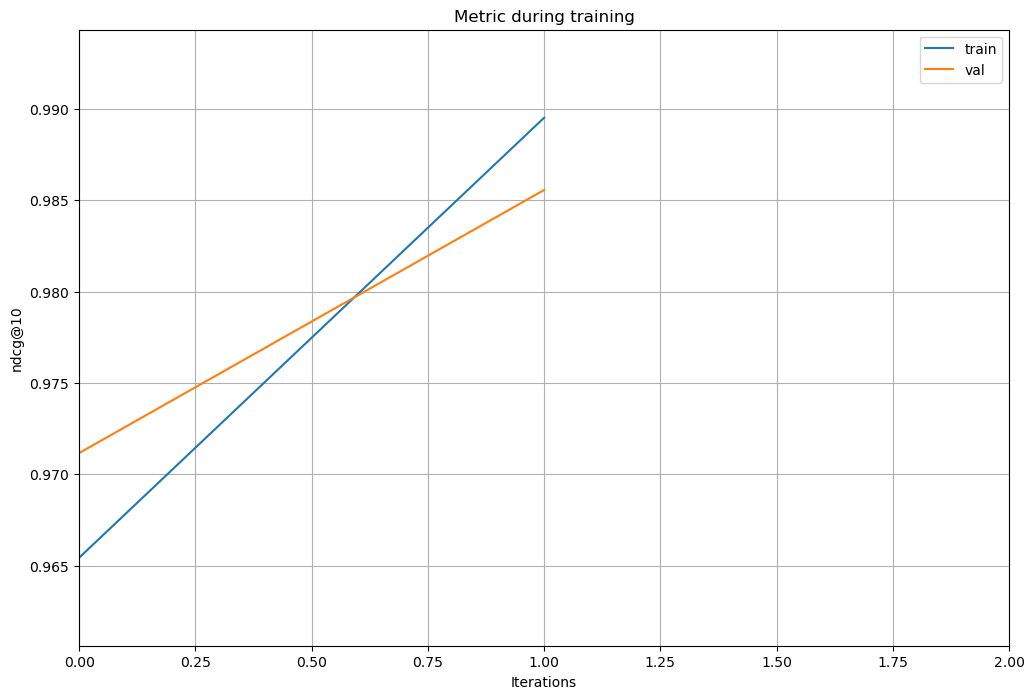

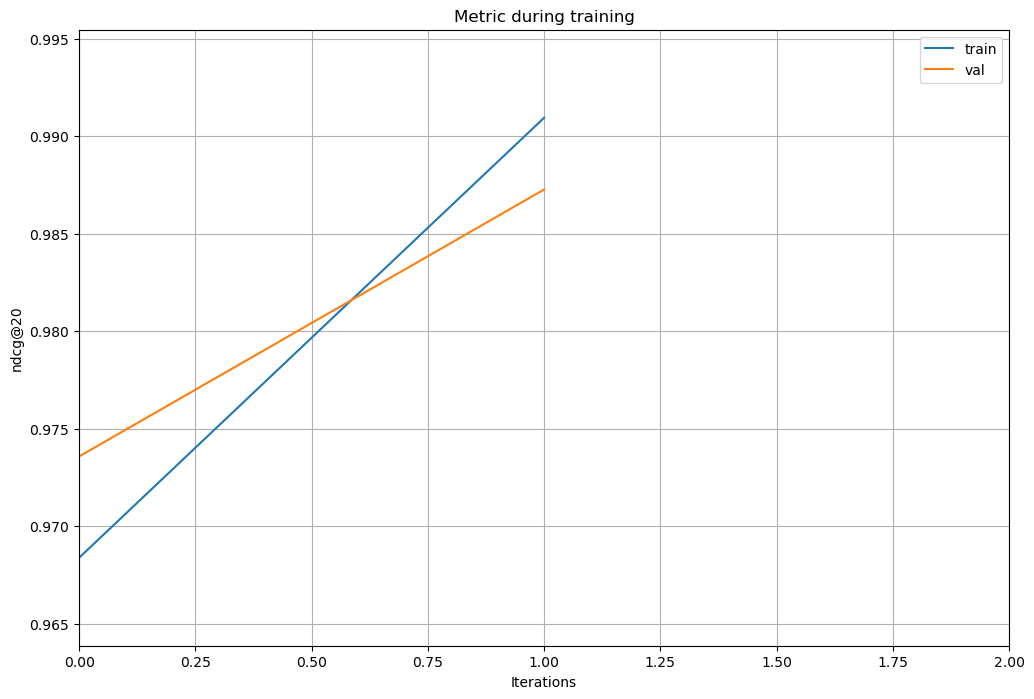

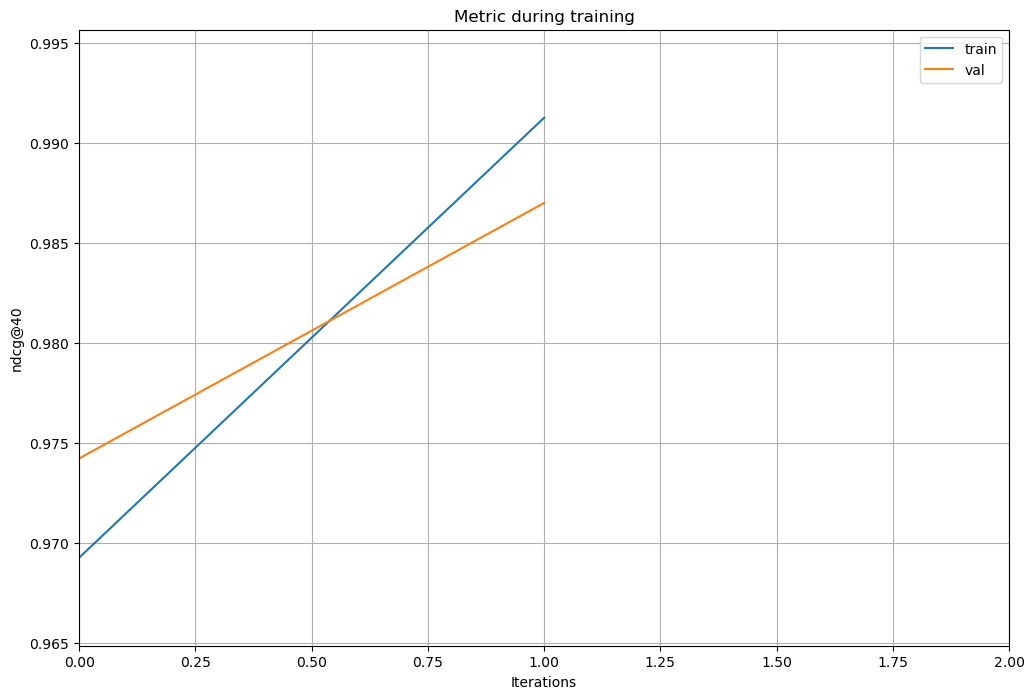

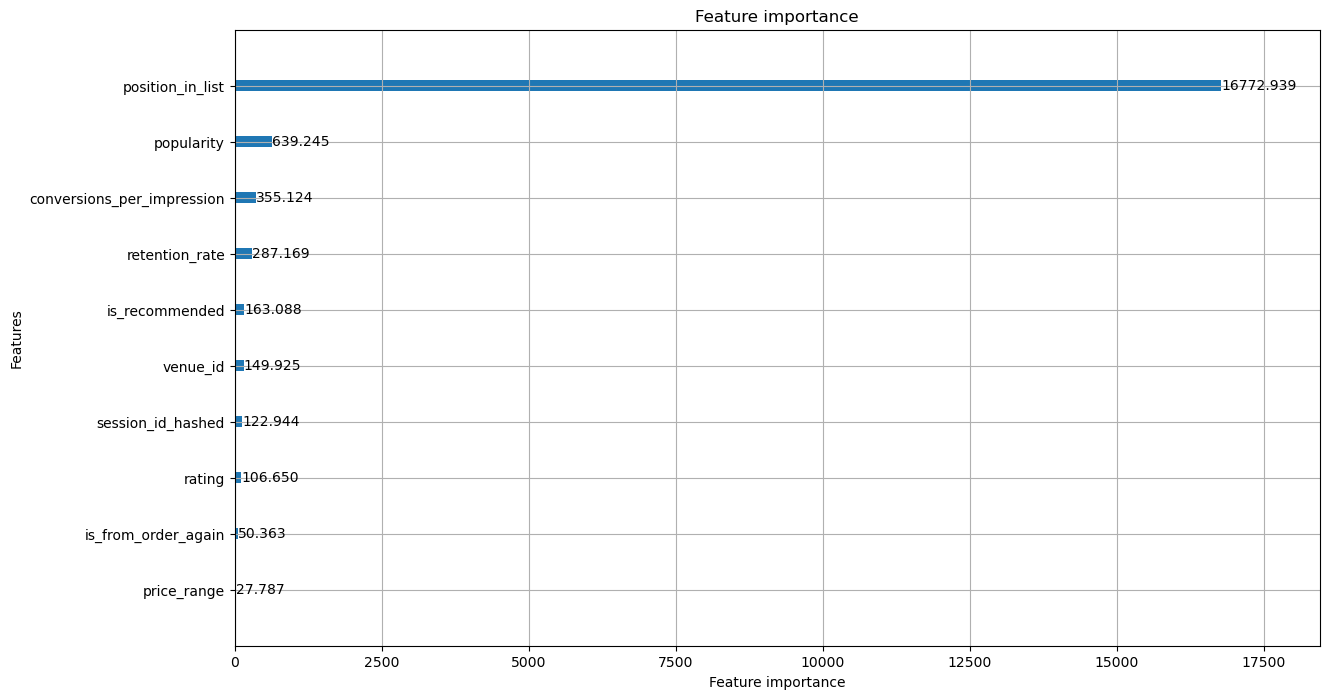

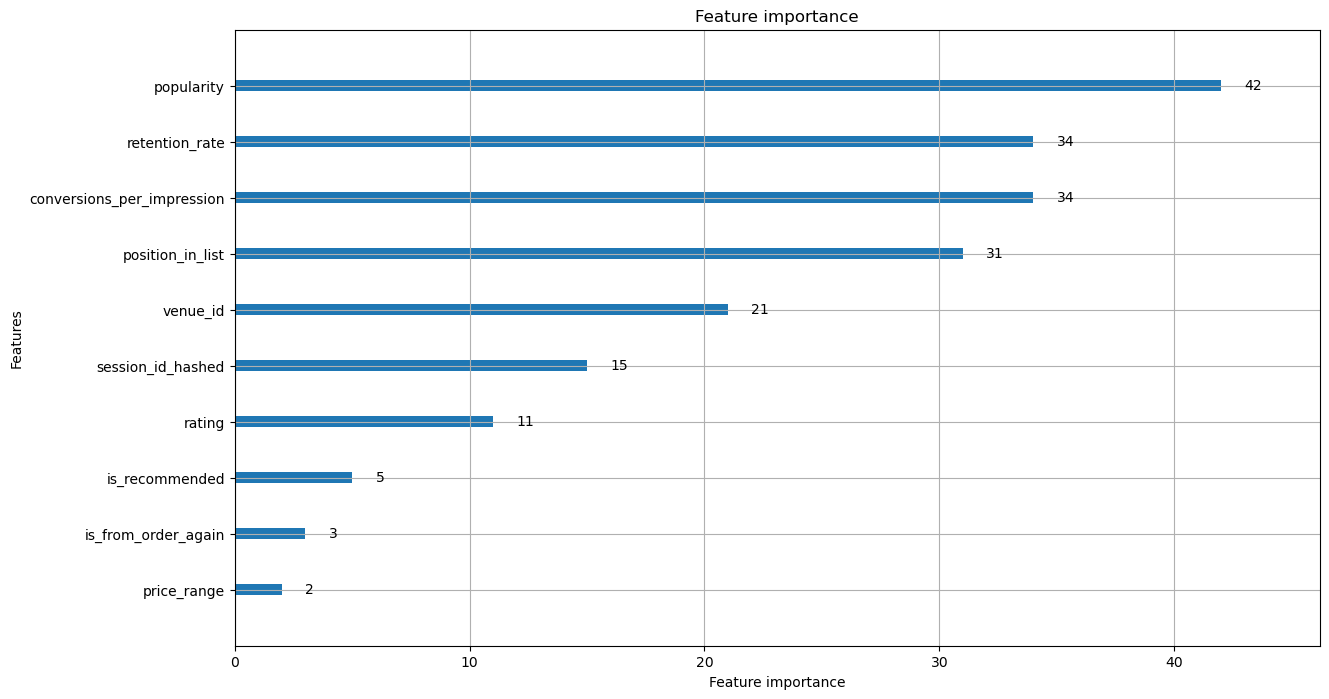

In [239]:
plot_lgb_report(lgb_model, evals_logs)

In [240]:
used_features = qa_features(lgb_model, features)

{'venue_id': 21, 'conversions_per_impression': 34, 'price_range': 2, 'rating': 11, 'popularity': 42, 'retention_rate': 34, 'session_id_hashed': 15, 'position_in_list': 31, 'is_from_order_again': 3, 'is_recommended': 5}
-------------------------------------------------------
Used features: 
['venue_id', 'conversions_per_impression', 'price_range', 'rating', 'popularity', 'retention_rate', 'session_id_hashed', 'position_in_list', 'is_from_order_again', 'is_recommended']
-------------------------------------------------------
passed 10 features and model used 10 of them
-------------------------------------------------------
these features were dropped: []


In [241]:
used_features

['venue_id',
 'conversions_per_impression',
 'price_range',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'position_in_list',
 'is_from_order_again',
 'is_recommended']

# save the trained model

In [242]:
%%time
lgb_model.save_model("/tmp/venues_ranking.pkl")

CPU times: user 5.22 ms, sys: 3.68 ms, total: 8.89 ms
Wall time: 3.92 ms


In [243]:
(
    ranking_data
    # .filter(pl.col("session_id_hashed")==2697534841382868)
    .sort(by=[group_column, rank_column], reverse=False)
    .groupby("session_id")
    .agg(
        pl.all().take([0,1, 2])
    )
    .explode("rating")
)

session_id,,purchased,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed
str,list[i64],list[i8],list[i64],list[i64],list[i8],list[i8],list[i8],list[i8],list[i64],list[f64],list[i64],f64,list[f64],list[f64],list[u64]
"""7302ee05-2a45-...","[10605028, 10605067, 10605093]","[0, 0, 0]","[9, 48, 74]","[1701525175334756094, 8276642495521859814, 5309789926057257527]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 934, 448]","[0.003067, 0.0, 0.067416]","[2, 1, 1]",9.0,"[0.0, 0.0, 0.0]","[0.3, 0.0, 0.0]","[10930653396951149898, 10930653396951149898, 10930653396951149898]"
"""7302ee05-2a45-...","[10605028, 10605067, 10605093]","[0, 0, 0]","[9, 48, 74]","[1701525175334756094, 8276642495521859814, 5309789926057257527]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 934, 448]","[0.003067, 0.0, 0.067416]","[2, 1, 1]",9.2,"[0.0, 0.0, 0.0]","[0.3, 0.0, 0.0]","[10930653396951149898, 10930653396951149898, 10930653396951149898]"
"""7302ee05-2a45-...","[10605028, 10605067, 10605093]","[0, 0, 0]","[9, 48, 74]","[1701525175334756094, 8276642495521859814, 5309789926057257527]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[168, 934, 448]","[0.003067, 0.0, 0.067416]","[2, 1, 1]",8.2,"[0.0, 0.0, 0.0]","[0.3, 0.0, 0.0]","[10930653396951149898, 10930653396951149898, 10930653396951149898]"
"""20180ab6-6780-...","[7745471, 7745476, 7745481]","[0, 0, 0]","[123, 128, 133]","[8436895510884739671, -3735324597557367519, 1701525175334756094]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[63, 152, 168]","[0.015707, 0.015789, 0.003067]","[1, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 0.0, 0.3]","[17029538552094393288, 17029538552094393288, 17029538552094393288]"
"""20180ab6-6780-...","[7745471, 7745476, 7745481]","[0, 0, 0]","[123, 128, 133]","[8436895510884739671, -3735324597557367519, 1701525175334756094]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[63, 152, 168]","[0.015707, 0.015789, 0.003067]","[1, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 0.0, 0.3]","[17029538552094393288, 17029538552094393288, 17029538552094393288]"
"""20180ab6-6780-...","[7745471, 7745476, 7745481]","[0, 0, 0]","[123, 128, 133]","[8436895510884739671, -3735324597557367519, 1701525175334756094]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[63, 152, 168]","[0.015707, 0.015789, 0.003067]","[1, 2, 2]",9.0,"[0.0, 0.0, 0.0]","[0.214286, 0.0, 0.3]","[17029538552094393288, 17029538552094393288, 17029538552094393288]"
"""6EB781FF-7E66-...","[6124864, 6124918, 6124938]","[0, 0, 0]","[16, 70, 90]","[6994327881557323832, 472199130850792437, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[726, 250, 860]","[0.052632, 0.026087, 0.007538]","[1, 1, 1]",9.0,"[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[3430450680933804056, 3430450680933804056, 3430450680933804056]"
"""6EB781FF-7E66-...","[6124864, 6124918, 6124938]","[0, 0, 0]","[16, 70, 90]","[6994327881557323832, 472199130850792437, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[726, 250, 860]","[0.052632, 0.026087, 0.007538]","[1, 1, 1]",9.0,"[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[3430450680933804056, 3430450680933804056, 3430450680933804056]"
"""6EB781FF-7E66-...","[6124864, 6124918, 6124938]","[0, 0, 0]","[16, 70, 90]","[6994327881557323832, 472199130850792437, -7194483610396448471]","[0, 0, 0]","[0, 0, 0]","[1, 0, 0]","[0, 0, 0]","[726, 250, 860]","[0.052632, 0.026087, 0.007538]","[1, 1, 1]",9.0,"[0.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[3430450680933804056, 3430450680933804056, 3430450680933804056]"


In [244]:
def calculate_ndcg_score(y_true: pl.Series, y_pred:pl.Series):
    return pl.Series([ndcg_score(y_true=y_true, y_score=y_pred)], dtype=pl.Float64)

In [245]:
predictions = generate_predictions(test_set, lgb_model, features_to_use=features)
predictions_pl = pl.DataFrame(predictions)

In [255]:
predictions_pl

column_0,purchased,session_id,position_in_list,venue_id,has_seen_venue_in_this_session,is_new_user,is_from_order_again,is_recommended,_right,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed,pred_has_seen_venue_in_this_session,predicted_popularity
i64,i8,str,i64,i64,i8,i8,i8,i8,i64,f64,i64,f64,f64,f64,u64,f64,i64
12099500,0,"""D9D4977A-97A9-...",46,6994327881557323832,0,0,1,0,726,0.052632,1,9.0,0.0,0.0,2697534841382868,-1.170497,51
12099563,0,"""D9D4977A-97A9-...",109,-1012604272228201392,0,0,0,0,733,0.019934,2,8.6,0.0,0.333333,2697534841382868,-1.8937,98
12099581,0,"""D9D4977A-97A9-...",127,3257242292074930225,0,0,0,0,398,0.0,2,8.8,0.0,0.214286,2697534841382868,-2.104542,102
12099535,0,"""D9D4977A-97A9-...",81,472199130850792437,0,0,0,0,250,0.026087,1,9.0,0.0,1.0,2697534841382868,-0.766547,36
12099606,0,"""D9D4977A-97A9-...",152,1744504799796043168,0,0,0,0,736,0.0,1,7.6,0.0,0.0,2697534841382868,-2.473213,114
12099623,0,"""D9D4977A-97A9-...",169,-5723001116090356006,0,0,0,0,1132,0.017143,3,9.0,0.0,0.1000005,2697534841382868,-2.421916,110
12099587,0,"""D9D4977A-97A9-...",133,-9076052207444688139,0,0,1,0,409,0.0,2,8.6,0.0,0.0,2697534841382868,-2.104542,103
12099530,0,"""D9D4977A-97A9-...",76,6232322477246922987,0,0,1,0,433,0.035461,2,9.0,0.098332,0.272727,2697534841382868,-1.193404,53
12099532,0,"""D9D4977A-97A9-...",78,8220935099878472881,0,0,0,0,682,0.069124,2,7.6,0.125688,0.193548,2697534841382868,-1.694558,78


In [246]:
"has_seen_venue_in_this_session"

'has_seen_venue_in_this_session'

In [247]:
def drop_sessions_with_no_interactions(ranking_data):
    active_sessions = (
        ranking_data
        .filter(pl.col(label_column)==1)
        .select("session_id","position_in_list", "popularity").sort("session_id").groupby("session_id").count().sort("count")\
        .filter(pl.col("count")>1).select("session_id")
    )
    active_ranking_data = ranking_data.join(active_sessions, on="session_id")

    return active_ranking_data

In [259]:
active_ranking_data = drop_sessions_with_no_interactions(predictions_pl)

In [260]:
active_ranking_data.groupby("session_id").count()
# .filter(
#     (9<=pl.col("popularity"))
#     &
#     (pl.col("popularity")<=10)
#     )


session_id,count
str,u32
"""2D46A024-4F99-...",228
"""6e0dc8cf-d73b-...",29
"""6a52403f-0330-...",120
"""A239099F-A679-...",208
"""09B87882-D1B0-...",92
"""45E01F8C-3EFC-...",64
"""CA76B587-4DDA-...",44
"""c5732db9-5bb3-...",83
"""93d3f258-0b12-...",223


In [261]:
active_ranking_data[["session_id", "has_seen_venue_in_this_session", "position_in_list", "popularity"]].groupby("session_id").agg(
    [
        pl.count("position_in_list").count(),
        pl.count("popularity").count(),

    ]
).filter(
    (pl.col("position_in_list")>1)
    |
    (pl.col("popularity")>1)
    )

session_id,position_in_list,popularity
str,u32,u32
"""4547B3AA-4A8E-...",252,252
"""DB8A6549-1989-...",42,42
"""4D4A503E-ABBB-...",55,55
"""2e8afe03-4f1c-...",336,336
"""DC53707B-A3EC-...",229,229
"""f1566860-dda5-...",290,290
"""C86A2A55-8642-...",87,87
"""074b4bdf-ea49-...",44,44
"""5f3819c0-665d-...",277,277


In [262]:
import numpy as np
def my_ndcg(y_true, y_pred):
    y_true = np.asarray([y_true])
    y_pred = np.asarray([y_pred])
    return ndcg_score(y_true=y_true, y_score = y_pred)

In [263]:
import numpy as np
from sklearn.metrics import ndcg_score


In [264]:
%%time
baseline_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('baseline_ndcg')
    ])
)

CPU times: user 741 ms, sys: 0 ns, total: 741 ms
Wall time: 699 ms


In [265]:
predictions_pl.columns

['column_0',
 'purchased',
 'session_id',
 'position_in_list',
 'venue_id',
 'has_seen_venue_in_this_session',
 'is_new_user',
 'is_from_order_again',
 'is_recommended',
 '_right',
 'conversions_per_impression',
 'price_range',
 'rating',
 'popularity',
 'retention_rate',
 'session_id_hashed',
 'pred_has_seen_venue_in_this_session',
 'predicted_popularity']

In [266]:
%%time
model_ndcg_per_sessions = (
    active_ranking_data
    .filter(pl.col(label_column)==1)
    .groupby("session_id")
    .agg([
        pl.apply(
            [pl.col('position_in_list'), pl.col("predicted_popularity")], lambda s: my_ndcg(s[0],s[1]) ).alias('model_ndcg')
    ])
)

CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.29 s


In [270]:
metric_columns = ["baseline_ndcg", "model_ndcg"]

In [278]:
predictions_pl.join(baseline_ndcg_per_sessions, on="session_id").join(model_ndcg_per_sessions, on="session_id")[ used_features + metric_columns].with_columns(
    [
        (pl.col("model_ndcg")-pl.col("baseline_ndcg")).alias("ndcg_diff")
    ]
).groupby("venue_id").mean()

venue_id,conversions_per_impression,price_range,rating,popularity,retention_rate,session_id_hashed,position_in_list,is_from_order_again,is_recommended,baseline_ndcg,model_ndcg,ndcg_diff
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5349742449137229592,0.219792,2.0,9.0,5.122831,0.666666,9.4606e18,112.6,0.0125,0.01875,0.848581,0.941321,0.092741
7281880014918871216,0.094359,1.0,8.2,2.445878,0.235295,9.2392e18,234.064815,0.084259,0.023148,0.815506,0.938453,0.122947
8335233138680167880,0.029973,3.0,9.0,2.44014,0.144887,9.3267e18,328.755687,0.019782,0.021761,0.800382,0.938592,0.13821
7200224660315769632,0.287278,1.0,8.6,5.747729,0.353287,9.3290e18,56.124324,0.275676,0.021622,0.819631,0.938797,0.119166
4217103872302339384,0.433093,1.0,8.6,2.319964,0.326087,8.9420e18,21.191176,0.492647,0.029412,0.806861,0.944668,0.137807
7692032668730876736,0.167068,3.0,9.0,7.616724,0.39979,9.0962e18,67.807339,0.321101,0.029817,0.810321,0.935635,0.125314
6663247888677393976,0.121951,2.0,7.6,0.100583,0.068183,9.1908e18,279.19274,0.010372,0.01815,0.803888,0.936395,0.132507
1338844988568014392,0.134358,1.0,9.0,0.498784,0.475609,9.0828e18,230.916168,0.05988,0.023952,0.815839,0.942763,0.126923
-6040094382371391944,0.02381,2.0,7.8,0.0,0.0,9.2144e18,383.93766,0.040137,0.027327,0.805714,0.940646,0.134932
